In [3]:
import tensorflow as tf
import os 
import numpy as np
import cv2
from PanGan_2 import PanGan
from DataSet import DataSet
from config import FLAGES
import scipy.io as scio
import time
import tifffile
from osgeo import gdal

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('pan_size',
                           default_value=None,
                           docstring='pan image size')
tf.app.flags.DEFINE_string('ms_size',
                           default_value=None,
                           docstring='ms image size')
tf.app.flags.DEFINE_integer('batch_size',
                           default_value=1,
                           docstring='img batch')
tf.app.flags.DEFINE_integer('num_spectrum',
                           default_value=4,
                           docstring='spectrum num')
tf.app.flags.DEFINE_integer('ratio',
                           default_value=4,
                           docstring='pan image/ms img')
tf.app.flags.DEFINE_string('model_path',
                           default_value='./model/qk/Generator-107000',

                           docstring='pan image/ms img') 
tf.app.flags.DEFINE_string('test_path',
                           default_value='./data/test_gt',
                           docstring='test img data')                            
tf.app.flags.DEFINE_string('result_path',
                           default_value='./result',
                           docstring='result img')                          
tf.app.flags.DEFINE_boolean('norm',
                           default_value=True,
                           docstring='if norm') 

In [6]:
def gdal_read(path,name):
    data=gdal.Open(path)
    w=data.RasterXSize
    h=data.RasterYSize
    img=data.ReadAsArray(0,0,w,h)
    if name == 'ms':
        img=np.transpose(img,(1,2,0))
    img=(img-1023.5)/1023.5
    return img

In [7]:
def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img

In [8]:
def img_write(img_array,save_path):
    datatype=gdal.GDT_UInt16
    h,w,c=img_array.shape
    driver=gdal.GetDriverByName('GTiff')
    data=driver.Create(save_path, w, h, c, datatype)
    for i in range(c):
        data.GetRasterBand(i+1).WriteArray(img_array[:,:,i])
    del data

In [9]:
def read_img(pan_test_path, ms_test_path, img_name, FLAGS=None):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
    return pan_img, ms_img

In [10]:
def main(argv):
    if not os.path.exists(FLAGS.result_path):
        os.makedirs(FLAGS.result_path)
    model=PanGan(FLAGS.pan_size,FLAGS.ms_size, FLAGS.batch_size, FLAGS.num_spectrum, FLAGS.ratio,0.001, 0.99, 1000,False)
    saver=tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, FLAGS.model_path)
        ms_test_path= FLAGS.test_path + '/lrms'
        pan_test_path=FLAGS.test_path + '/pan'
        for img_name in os.listdir(ms_test_path):
            start=time.time()
            print(img_name)
            pan, ms = read_img(pan_test_path, ms_test_path, img_name,FLAGS)
            start=time.time()
            PanSharpening,error,error2= sess.run([model.PanSharpening_img,model.g_spectrum_loss,model.g_spatial_loss], feed_dict={model.pan_img:pan, model.ms_img:ms})
            PanSharpening=PanSharpening*127.5+127.5
            PanSharpening=PanSharpening.squeeze()
            PanSharpening=PanSharpening.astype('uint8')
            PanSharpening=cv2.cvtColor(PanSharpening[:,:,0:3], cv2.COLOR_BGR2RGB)
            end=time.time()
            
            print(end-start)
            
            save_name=img_name.split('.')[0] + '.TIF'
            save_path=os.path.join(FLAGS.result_path,save_name)
            
            cv2.imwrite(save_path, PanSharpening)
            img_write(PanSharpening,save_path)
            
            m1 = ms[0]
            p1 = pan[0]
                       
            print("pansharp",PanSharpening.shape,"m1",m1.shape,"p1",p1.shape)
            cv2.imshow("ms",m1)
            cv2.imshow("pan",p1)
            cv2.imshow("pansharpened",PanSharpening)
            tifffile.imsave(save_path, PanSharpening)
            print(f"{'-'*20} \n{img_name} done\nspectrum error = {str(error)} \nspatial error ={str(error2)}")
            cv2.waitKey(0)
 

In [11]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

In [29]:
import matplotlib.pyplot as plt
def display(pan,ms,fused,size=(25,8)):
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap='gray')
    ax[1].imshow(ms[0][:,:,0], cmap='gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap='gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap='gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap='gist_earth')
    ax[5].imshow(pan[0], cmap='gray')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()

In [ ]:
tf.app.run()

In [10]:
del_all_flags(FLAGS)

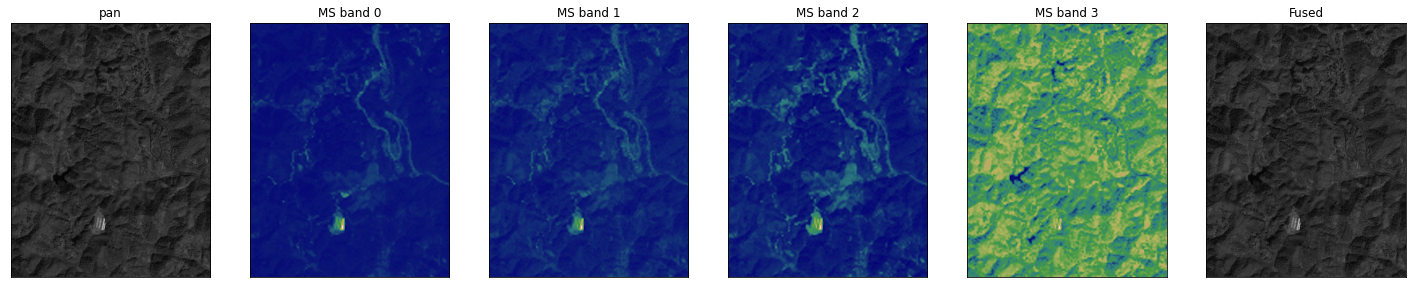

In [30]:
pan,ms = read_img("data\\test_gt_gf\\pan","data\\test_gt_gf\\lrms",'crop8bit_5.npy')
display(pan,ms,pan)

In [32]:
os.path.exists('result\crop8bit_1.TIF')

True

In [36]:
im = cv2.imread('result\crop8bit_1.TIF')
cv2.imshow('im',im)